In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import norm  # Add this import
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

df = pd.read_csv('D:\FYP\Data\Data\FYP_code\RORL\Final_Data.csv')

class RealOptionsQLBS:
    """
    Q-Learning Black-Scholes (QLBS) model for Real Options Valuation.

    This class implements both traditional Black-Scholes-Merton (BSM) and
    QLBS approaches for valuing the four types of real options:
    1. Option to Delay (Timing Option)
    2. Option to Expand (Growth Option)
    3. Option to Contract (Shrink Option)
    4. Option to Abandon (Exit Option)
    """

    def __init__(self, S0, K, T, r, sigma, option_type='delay',
                n_steps=24, n_paths=100000, lambda_risk=0.0,
                contract_factor=0.5, basis_degree=2,
                extension_factor=1.5, reopening_cost=0.3,
                default_penalty=0.1, shutdown_cost=0.2):
        """
        Initialize the Real Options QLBS model.

        Parameters:
        -----------
        S0 : float
            Initial value of the underlying asset (present value of expected cash flows)
        K : float
            Strike price (investment cost)
        T : float
            Time to maturity in years
        r : float
            Risk-free interest rate (annual, expressed as a decimal)
        sigma : float
            Annual volatility of the underlying asset (expressed as a decimal)
        option_type : str
            Type of real option: 'delay', 'expand', 'extend', 're-open',
                                'default', 'contract', 'abandon', 'shut-down'
        n_steps : int
            Number of time steps in the simulation
        n_paths : int
            Number of Monte Carlo paths
        lambda_risk : float
            Risk aversion parameter for Q-function
        contract_factor : float
            Factor by which to multiply the underlying in 'contract' option
        basis_degree : int
            Degree of polynomial basis functions for regression
        extension_factor : float
            Factor representing additional value from extending a project
        reopening_cost : float
            Cost of reopening as a fraction of strike price
        default_penalty : float
            Additional penalty cost for defaulting as a fraction of strike price
        shutdown_cost : float
            Cost of shutting down operations as a fraction of strike price
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()
        self.n_steps = n_steps
        self.n_paths = n_paths
        self.lambda_risk = lambda_risk
        self.contract_factor = contract_factor
        self.basis_degree = basis_degree
        self.extension_factor = extension_factor
        self.reopening_cost = reopening_cost
        self.default_penalty = default_penalty
        self.shutdown_cost = shutdown_cost
        self.dt = T / n_steps

        # Validate option type
        valid_options = ['delay', 'expand', 'extend', 're-open',
                        'default', 'contract', 'abandon', 'shut-down']
        if self.option_type not in valid_options:
            raise ValueError(f"Option type must be one of {valid_options}")

        # Initialize simulation results
        self.S = None
        self.V = None
        self.phi = None
        self.bsm_price = None
        self.qlbs_price = None
        self.q_price = None

    def black_scholes_merton(self):
        """Calculate the option value using Black-Scholes-Merton formula"""

        # For put-like options, convert to put valuation
        is_put = self.option_type in ['default', 'contract', 'abandon', 'shut-down']

        # Modify parameters based on option type
        S = self.S0
        K = self.K

        if self.option_type == 'contract':
            S = self.contract_factor * self.S0
        elif self.option_type == 'extend':
            S = self.extension_factor * self.S0
        elif self.option_type == 're-open':
            K = self.K + (self.K * self.reopening_cost)
        elif self.option_type == 'default':
            K = self.K - (self.K * self.default_penalty)
        elif self.option_type == 'shut-down':
            K = self.K - (self.K * self.shutdown_cost)

        K = max(K, 1e-12)  # Avoid zero or negative investment cost

        # BSM parameters
        d1 = ((np.log(S / K) +
            (self.r + 0.5 * self.sigma**2) * self.T) /
            (self.sigma * np.sqrt(self.T)))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        if not is_put:  # Call option (delay, expand, extend, re-open)
            self.bsm_price = (S * norm.cdf(d1) -
                            K * np.exp(-self.r * self.T) * norm.cdf(d2))
        else:  # Put option (default, contract, abandon, shut-down)
            self.bsm_price = (K * np.exp(-self.r * self.T) * norm.cdf(-d2) -
                            S * norm.cdf(-d1))

        return self.bsm_price

    def simulate_paths(self):
        """Simulate asset price paths using Geometric Brownian Motion"""
        np.random.seed(42)  # For reproducibility

        # Initialize paths array
        self.S = np.zeros((self.n_paths, self.n_steps + 1))
        self.S[:, 0] = self.S0

        # Generate random variables for simulation
        Z = np.random.normal(0, 1, size=(self.n_paths, self.n_steps))

        # Simulate paths
        for t in range(self.n_steps):
            self.S[:, t+1] = self.S[:, t] * np.exp(
                (self.r - 0.5 * self.sigma**2) * self.dt +
                self.sigma * np.sqrt(self.dt) * Z[:, t]
            )

        return self.S

    def calculate_terminal_payoff(self):
        """Calculate the terminal payoff based on option type"""
        S_T = self.S[:, -1]

        if self.option_type == 'delay':
            # Option to delay (call option)
            return np.maximum(S_T - self.K, 0)
        elif self.option_type == 'expand':
            # Option to expand (call option)
            return np.maximum(S_T - self.K, 0)
        elif self.option_type == 'extend':
            # Option to extend project life (call option)
            # Extension creates additional value represented by extension_factor
            return np.maximum(self.extension_factor * S_T - self.K, 0)
        elif self.option_type == 're-open':
            # Option to re-open operations (call option)
            # Reopening has some cost represented by reopening_cost * K
            reopening_cost = self.K * self.reopening_cost
            return np.maximum(S_T - self.K - reopening_cost, 0)
        elif self.option_type == 'default':
            # Option to default (put option)
            # Default may incur a penalty represented by default_penalty * K
            default_penalty = self.K * self.default_penalty
            return np.maximum(self.K - S_T - default_penalty, 0)
        elif self.option_type == 'contract':
            # Option to contract (put option)
            return np.maximum(self.K - self.contract_factor * S_T, 0)
        elif self.option_type == 'abandon':
            # Option to abandon (put option)
            return np.maximum(self.K - S_T, 0)
        elif self.option_type == 'shut-down':
            # Option to shut down temporarily (put option)
            # Shutdown has some cost represented by shutdown_cost * K
            shutdown_cost = self.K * self.shutdown_cost
            return np.maximum(self.K - S_T - shutdown_cost, 0)

    def qlbs_value_function(self):
        """
        Calculate option value using QLBS Value Function approach (risk-neutral)
        This is the basic QLBS method without explicit risk aversion.
        """
        # Simulate asset price paths if not already simulated
        if self.S is None:
            self.simulate_paths()

        # Calculate terminal payoff
        self.V = self.calculate_terminal_payoff()
        self.phi = np.zeros(self.n_steps)

        # Backward induction
        for t in range(self.n_steps - 1, -1, -1):
            # Create polynomial basis features for regression
            X = np.column_stack([self.S[:, t]**i for i in range(self.basis_degree + 1)])

            # Fit linear regression model
            reg = LinearRegression().fit(X, self.V)

            # Compute continuation value
            continuation_value = reg.predict(X)

            # For American-style options, we could check for early exercise here
            # For European-style, just use the continuation value
            self.V = np.exp(-self.r * self.dt) * continuation_value

            # Calculate optimal hedge ratio (delta)
            if t < self.n_steps - 1:
                # Calculate covariance and variance for hedge ratio
                cov = np.cov(np.vstack([self.V, self.S[:, t+1]]))[0, 1]
                var = np.var(self.S[:, t+1])

                # Optimal hedge ratio
                self.phi[t] = cov / var if var > 1e-10 else 0

        # Option price at t=0 is the mean of V at t=0
        self.qlbs_price = np.mean(self.V)
        return self.qlbs_price, self.phi[0]

    def qlbs_q_function(self):
        """
        Calculate option value using QLBS Q-Function approach with risk aversion.
        This method explicitly incorporates a risk penalty term.
        """
        # Simulate asset price paths if not already simulated
        if self.S is None:
            self.simulate_paths()

        # Calculate terminal payoff
        self.V = self.calculate_terminal_payoff()
        self.phi = np.zeros(self.n_steps)

        # Initialize portfolio value vector
        portfolio = np.zeros_like(self.V)

        # Backward induction
        for t in range(self.n_steps - 1, -1, -1):
            # Define Q-function optimization
            def objective_function(phi_t):
                # Calculate portfolio value at t+1
                if t == self.n_steps - 1:
                    # At terminal step, portfolio value equals option payoff
                    portfolio_next = self.V
                else:
                    # Otherwise, calculate using hedging formula
                    portfolio_next = (phi_t * self.S[:, t+1] +
                                  (1 + self.r * self.dt) * (portfolio - phi_t * self.S[:, t]))

                # Risk penalty term (variance of hedging error)
                risk_penalty = self.lambda_risk * np.var(portfolio_next - self.V)

                # Q-function is expected portfolio value minus risk penalty
                q_value = np.mean(portfolio_next) - risk_penalty

                # Negative Q-value since we're minimizing
                return -q_value

            # Find optimal hedge ratio by minimizing negative Q-function
            result = minimize(objective_function, x0=[0.0], method='BFGS')
            optimal_phi = result.x[0]
            self.phi[t] = optimal_phi

            # Update portfolio value for next iteration
            if t > 0:
                portfolio = (self.phi[t] * self.S[:, t] +
                          np.exp(-self.r * self.dt) * (self.V - self.phi[t] * self.S[:, t]))
            else:
                # At t=0, calculate the final option value
                portfolio = (self.phi[0] * self.S0 +
                          np.exp(-self.r * self.dt) * (self.V - self.phi[0] * self.S0))

            # Update option value for next iteration
            if t > 0:
                # Create polynomial basis features for regression
                X = np.column_stack([self.S[:, t-1]**i for i in range(self.basis_degree + 1)])

                # Fit linear regression model
                reg = LinearRegression().fit(X, self.V)

                # Compute continuation value
                self.V = np.exp(-self.r * self.dt) * reg.predict(X)

        # Option price at t=0
        self.q_price = np.mean(portfolio)
        return self.q_price, self.phi[0]

    def value_option(self):
        """
        Value the option using all methods and return results.
        """
        # Calculate prices
        bsm = self.black_scholes_merton()
        v_func, v_phi = self.qlbs_value_function()

        # Q-function if risk aversion is specified
        q_func, q_phi = None, None
        if self.lambda_risk > 0:
            q_func, q_phi = self.qlbs_q_function()

        results = {
            'option_type': self.option_type,
            'S0': self.S0,
            'K': self.K,
            'T': self.T,
            'r': self.r,
            'sigma': self.sigma,
            'BSM_price': bsm,
            'QLBS_V_price': v_func,
            'QLBS_V_hedge': v_phi,
            'QLBS_Q_price': q_func,
            'QLBS_Q_hedge': q_phi,
            'lambda_risk': self.lambda_risk
        }

        return results


def test_all_option_types(df):
    """Test all real option types using actual project data"""

    # Get unique project phases for loading parameters
    phases = df['Project_Phase'].unique()

    # Default fallback values if data is missing
    default_params = {
        'price': 100.0,
        'Cost_of_Waiting': 80.0,
        'interest_rate': 0.05,
        'price_volatility': 0.25,
        'Total_Revenue': 1000000000,
        'CAPEX': 800000000,
        'OPEX': 200000000,
        'FCF': 500000000
    }

    # Helper function to get valid data with fallbacks
    def get_valid_data(phase):
        phase_data = df[df['Project_Phase'] == phase]
        if len(phase_data) == 0:
            return pd.Series(default_params)
        return phase_data.iloc[-1]

    # Load data for each phase
    rd_data = get_valid_data('R&D')
    operation_data = get_valid_data('Operation')
    construct_data = get_valid_data('Construction')

    # Define parameters for all 8 option types
    option_params = {
        # Call Options
        'delay': {
            'S0': float(rd_data['price']),
            'K': float(rd_data['Cost_of_Waiting']),
            'T': 5.0,
            'r': float(rd_data['interest_rate']),
            'sigma': float(rd_data['price_volatility']/100 if rd_data['price_volatility'] > 1 else rd_data['price_volatility'])
        },
        'expand': {
            'S0': float(construct_data['Total_Revenue']/1e9),
            'K': float(construct_data['CAPEX']/1e8),
            'T': 5.0,
            'r': float(construct_data['interest_rate']),
            'sigma': float(construct_data['price_volatility']/100 if construct_data['price_volatility'] > 1 else construct_data['price_volatility'])
        },
        'extend': {
            'S0': float(operation_data['Total_Revenue']/1e9),
            'K': float(operation_data['CAPEX']/1e8) if operation_data['CAPEX'] > 0 else float(operation_data['OPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility']),
            'extension_factor': 1.5
        },
        're-open': {
            'S0': float(operation_data['Total_Revenue']/1e9),
            'K': float(operation_data['CAPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility']),
            'reopening_cost': 0.3
        },
        # Put Options
        'default': {
            'S0': float(operation_data['FCF']/1e8),
            'K': float(operation_data['CAPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility']),
            'default_penalty': 0.1
        },
        'contract': {
            'S0': float(operation_data['Total_Revenue']/1e9),
            'K': float(operation_data['OPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility']),
            'contract_factor': 0.5
        },
        'abandon': {
            'S0': float(operation_data['FCF']/1e8),
            'K': float(operation_data['CAPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility'])
        },
        'shut-down': {
            'S0': float(operation_data['Total_Revenue']/1e9),
            'K': float(operation_data['OPEX']/1e8),
            'T': 5.0,
            'r': float(operation_data['interest_rate']),
            'sigma': float(operation_data['price_volatility']/100 if operation_data['price_volatility'] > 1 else operation_data['price_volatility']),
            'shutdown_cost': 0.2
        }
    }

    # Ensure non-zero and positive values for all parameters
    def validate_params(params):
        params['S0'] = max(params['S0'], 1e-6)
        params['K'] = max(params['K'], 1e-6)
        params['T'] = max(params['T'], 0.1)
        params['r'] = max(params['r'], 0.01)
        params['sigma'] = max(params['sigma'], 0.01)
        return params

    # Calculate values for all option types
    results = {}
    for option_type, params in option_params.items():
        try:
            # Validate parameters
            params = validate_params(params)
            # print(f"\nCalculating {option_type.capitalize()} Option...")
            # print(f"Parameters: {params}")

            # Create model with risk aversion
            model = RealOptionsQLBS(option_type=option_type, **params, lambda_risk=0.1)
            results[option_type] = model.value_option()

        except Exception as e:
            print(f"Error calculating {option_type}: {str(e)}")
            results[option_type] = {
                'BSM_price': 0.0,
                'QLBS_V_price': 0.0,
                'QLBS_Q_price': 0.0,
                'error': str(e)
            }

    # Format results for display
    results_table = []
    for option_type, result in results.items():
        option_class = 'Call' if option_type in ['delay', 'expand', 'extend', 're-open'] else 'Put'
        results_table.append({
            'Option Type': option_type.capitalize(),
            'Option Class': option_class,
            'BSM Price': result['BSM_price'],
            'V-Function Price': round(result['QLBS_V_price'], 4),
            'Q-Function Price': round(result['QLBS_Q_price'], 4),
            'V vs BSM Diff (%)': round((result['QLBS_V_price'] - result['BSM_price']) / result['BSM_price'] * 100 if result['BSM_price'] != 0 else float('0'), 4),
            'Q vs BSM Diff (%)': round((result['QLBS_Q_price'] - result['BSM_price']) / result['BSM_price'] * 100 if result['BSM_price'] != 0 else float('0'), 4)
        })

    results_df = pd.DataFrame(results_table)

    # Print formatted results
    print("\nCall Options:")
    print(results_df[results_df['Option Class'] == 'Call'].to_string(index=False))
    print("\nPut Options:")
    print(results_df[results_df['Option Class'] == 'Put'].to_string(index=False))

    return results


# Test with actual data
all_results = test_all_option_types(df)



Call Options:
Option Type Option Class  BSM Price  V-Function Price  Q-Function Price  V vs BSM Diff (%)  Q vs BSM Diff (%)
      Delay         Call   0.000000            0.0000            0.0536             0.0000             0.0000
     Expand         Call   0.179710            0.1797            0.1797            -0.0135            -0.0135
     Extend         Call   0.173112            0.1730            0.2062            -0.0377            19.0913
    Re-open         Call   0.355304            0.3553            0.3909            -0.0123            10.0291

Put Options:
Option Type Option Class    BSM Price  V-Function Price  Q-Function Price  V vs BSM Diff (%)  Q vs BSM Diff (%)
    Default          Put 0.000000e+00            0.0000            0.0432             0.0000       0.000000e+00
   Contract          Put 1.821938e-01            0.1822            0.2257             0.0119       2.387130e+01
    Abandon          Put 0.000000e+00            0.0000            0.0432            

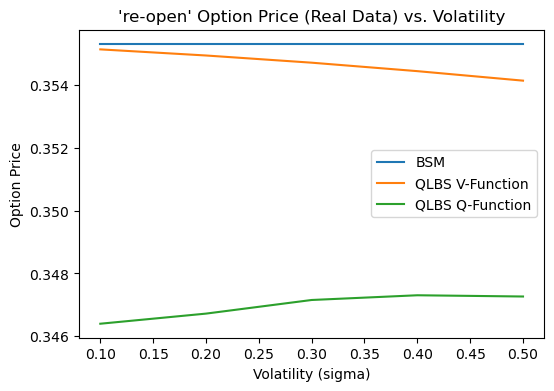

In [ ]:
# ...existing code...

import matplotlib.pyplot as plt

# Fetch "Operation" data from your DataFrame
operation_data = df[df['Project_Phase'] == 'Operation'].iloc[-1]

# Convert to real parameters; adjust the divisors as needed
operation_S0 = float(operation_data['Total_Revenue'] / 1e9)
operation_K = float(operation_data['CAPEX'] / 1e8)
operation_r = float(operation_data['interest_rate'])
operation_sigma = float(operation_data['price_volatility'] / 100
                        if operation_data['price_volatility'] > 1
                        else operation_data['price_volatility'])

sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
bsm_prices = []
qlbs_v_prices = []
qlbs_q_prices = []

for sv in sigma_values:
    model = RealOptionsQLBS(
        S0=operation_S0,
        K=operation_K,
        T=5.0,
        r=operation_r,
        sigma=sv,
        option_type='re-open',
        reopening_cost=0.3,
        lambda_risk=0.1
    )
    result = model.value_option()
    bsm_prices.append(result['BSM_price'])
    qlbs_v_prices.append(result['QLBS_V_price'])
    qlbs_q_prices.append(result['QLBS_Q_price'])

plt.figure(figsize=(6,4))
plt.plot(sigma_values, bsm_prices, label='BSM')
plt.plot(sigma_values, qlbs_v_prices, label='QLBS V-Function')
plt.plot(sigma_values, qlbs_q_prices, label='QLBS Q-Function')
plt.xlabel('Volatility (sigma)')
plt.ylabel('Option Price')
plt.title("'re-open' Option Price (Real Data) vs. Volatility")
plt.legend()
plt.show()

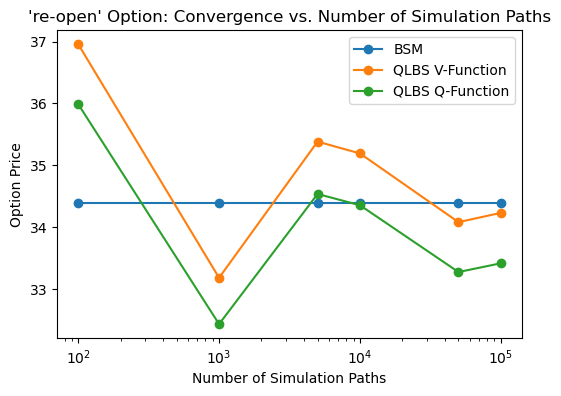

In [ ]:
# ...existing code...

# Value Convergence vs. Number of Simulation Paths for 're-open'
import matplotlib.pyplot as plt

path_counts = [100, 1000, 5000, 10000, 50000, 100000]
bsm_prices = []
qlbs_v_prices = []
qlbs_q_prices = []

for p in path_counts:
    model = RealOptionsQLBS(
        S0=100,
        K=80,
        T=5,
        r=0.05,
        sigma=0.3,
        option_type='re-open',
        reopening_cost=0.3,
        lambda_risk=0.1,
        n_paths=p
    )
    result = model.value_option()
    bsm_prices.append(result['BSM_price'])
    qlbs_v_prices.append(result['QLBS_V_price'])
    qlbs_q_prices.append(result['QLBS_Q_price'])

plt.figure(figsize=(6,4))
plt.plot(path_counts, bsm_prices, marker='o', label='BSM')
plt.plot(path_counts, qlbs_v_prices, marker='o', label='QLBS V-Function')
plt.plot(path_counts, qlbs_q_prices, marker='o', label='QLBS Q-Function')
plt.xlabel('Number of Simulation Paths')
plt.ylabel('Option Price')
plt.title("'re-open' Option: Convergence vs. Number of Simulation Paths")
plt.xscale('log')  # Helps visualize convergence on a log scale
plt.legend()
plt.show()